In [56]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [57]:
dmeeting = pd.read_parquet('./data/data_meeting.parquet')
dagenda = pd.read_parquet('./data/data_agenda.parquet')
data_speech1 = pd.read_parquet('./data/data_speech1.parquet')
data_speech2 = pd.read_parquet('./data/data_speech2.parquet')
data_speech3 = pd.read_parquet('./data/data_speech3.parquet')
parMem = pd.read_parquet('./data/parliament_members.parquet')

dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)

In [60]:

# group by meeting_id and agenda_item_id to count the number of speeches per agenda item per meeting and how many of those are labeled as NC vs C
plot_df = dspeech[["meeting_id", "agenda_item_id", "speech_item_id", "label"]]

# Custom aggregation function to calculate NC to C ratio
def c_nc_ratio(group):
    nc_count = sum(group == 'NC')
    c_count = sum(group == 'C')
    return c_count / (nc_count+c_count) if nc_count != 0 else 0  # Avoid division by zero

# Group by meeting_id and agenda_item_id, and apply the aggregations
plot_df = plot_df.groupby(["meeting_id", "agenda_item_id"]).agg(
    num_speech_items=("speech_item_id", "count"),
    C_NC_ratio=("label", c_nc_ratio)
).reset_index()

In [61]:
plot_df = pd.merge(plot_df, dagenda[["meeting_id","agenda_item_id"]], on=["meeting_id","agenda_item_id"])
plot_df = pd.merge(plot_df, dmeeting[["meeting_id","date"]], on="meeting_id")
# plot_df = plot_df.groupby("meeting_id").agg(num_speech_items=("num_speech_items", "sum"), C_NC_ratio=("C_NC_ratio", "sum"), date=("date","first")).reset_index()
# plot_df["num_speech_items"] = plot_df["num_speech_items"].apply(lambda x: (x/np.sum(plot_df["num_speech_items"])*100))
# Convert 'date' to datetime and set as index
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df.set_index('date', inplace=True)

In [65]:
# Resampling data to weekly, and calculating mean for the week
weekly_df = plot_df['C_NC_ratio'].resample('W').mean()
# Fill missing values. You can use 'ffill', 'bfill', or 'interpolate'.
# Here, I use interpolate to fill gaps with interpolated values
weekly_df.interpolate(inplace=True)

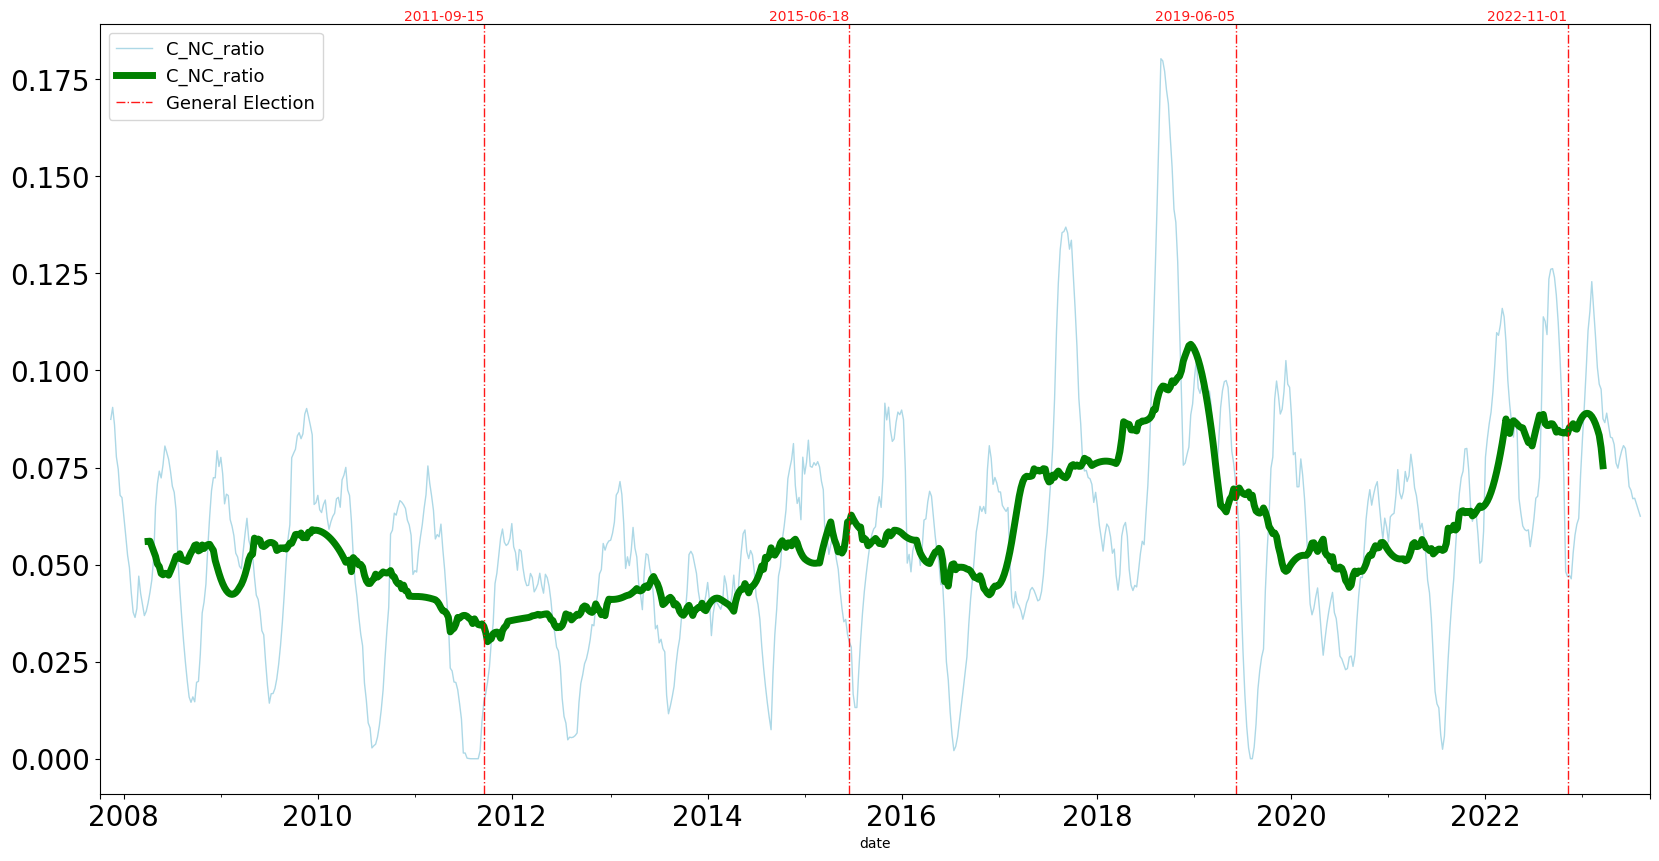

In [128]:

# Assuming weekly_df is your DataFrame
# Plot the rolling averages
weekly_df.rolling(window=12, center=True).mean().plot(color='lightblue', linewidth=1, fontsize=20)
weekly_df.rolling(window=52, center=True).mean().plot(figsize=(20, 10), linewidth=5, fontsize=20, color='green')

# Election dates
fv_elections = ['2022-11-01', '2019-06-05', '2015-06-18', '2011-09-15']
# Plotting vertical lines for election dates
for i, fv_election in enumerate(fv_elections):
    date = pd.to_datetime(fv_election)
    plt.axvline(date, color='red', linestyle='dashdot', linewidth=1, alpha=0.9, 
                label='General Election' if i == 0 else "")
    
    # Annotating the line
    plt.text(date, plt.gca().get_ylim()[1], fv_election,verticalalignment='bottom', horizontalalignment='right', color='red', alpha=0.9)

plt.legend(fontsize=13)
plt.show()



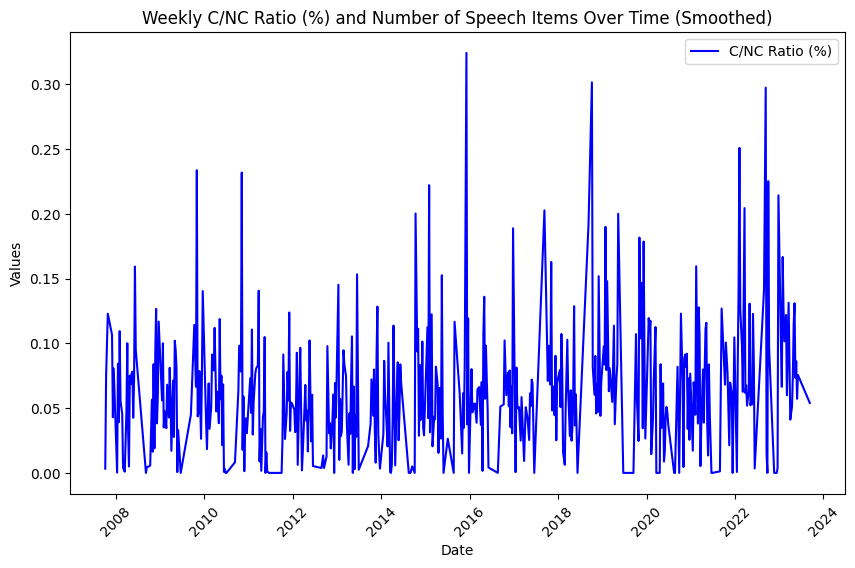

In [23]:


# Calculate rolling average (choose a window size that makes sense for your data)
# smoothed_df = weekly_df.rolling(window=4).mean()  # 4 weeks rolling window

# Plotting
plt.figure(figsize=(10, 6))

# Plot C_NC_ratio
plt.plot(weekly_df.index, weekly_df['C_NC_ratio'], label='C/NC Ratio (%)', color='blue')  # Multiplied by 100 for percentage

# Plot num_speech_items with transparency
# plt.plot(smoothed_df.index, smoothed_df['num_speech_items'], label='Number of Speech Items', color='red', alpha=0.5)  # alpha for transparency

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Weekly C/NC Ratio (%) and Number of Speech Items Over Time (Smoothed)')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()


## Andreas

## Eisuke

## Anders